# Using the Transformer Architecture for Next-Chord Prediction

## Data Preparation

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchinfo import summary

from src import chord_parser

In [2]:
data = pd.read_csv('../Data/data_tokenized_pitch_class.csv')
data["chords"] = data["chords"].apply(lambda x: torch.tensor(json.loads(x)))
data.head()

,url,title,artist,decade,genre,ratings,stars,chords
0,https://tabs.ultimate-guitar.com/tab/jeff-buck...,Hallelujah,Jeff Buckley,1990,Rock|Folk,51639.0,5.0,"[tensor(685), tensor(677), tensor(685), tensor..."
1,https://tabs.ultimate-guitar.com/tab/ed-sheera...,Perfect,Ed Sheeran,2010,Pop,44194.0,5.0,"[tensor(162), tensor(34), tensor(685), tensor(..."
2,https://tabs.ultimate-guitar.com/tab/elvis-pre...,Cant Help Falling In Love,Elvis Presley,1960,"Soundtrack|R&B, Funk & Soul",30059.0,5.0,"[tensor(685), tensor(162), tensor(677), tensor..."
3,https://tabs.ultimate-guitar.com/tab/eagles/ho...,Hotel California,Eagles,1970,Rock,28670.0,5.0,"[tensor(173), tensor(422), tensor(397), tensor..."
4,https://tabs.ultimate-guitar.com/tab/radiohead...,Creep,Radiohead,1990,Rock,28606.0,5.0,"[tensor(162), tensor(83), tensor(685), tensor(..."


In [3]:
parser = chord_parser.Main()

In [4]:
augmentation_map = torch.tensor(np.load('../Data/augmentation_map.npy', allow_pickle=True))

with open("../Data/token_to_chord.json", "r") as fp:
    token_to_chord = json.load(fp)
# Convert the dictionary keys to integers
token_to_chord = {int(k): v for k, v in token_to_chord.items()}

In [5]:
VOCAB_SIZE = len(token_to_chord) + 2 # Start and end of sequence tokens
VOCAB_SIZE

1035

## Dataset

In [6]:
class ChordDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def augment(self, chords):
        """Change the root note of the chords by a random amount"""
        move_by = torch.randint(0, 12, [1]).item()
        return augmentation_map[chords, move_by]
        
    def pad(self, chords):
        """Pad the input tensor of shape [n] into shape [256] with zeros and special tokens"""
        out = torch.zeros((256))
        out[0] = VOCAB_SIZE - 2 # Start of sequence token
        out[1:1 + len(chords)] = chords
        out[1 + len(chords)] = VOCAB_SIZE - 1 # End of sequence token
        return out

    def __getitem__(self, index):
        x = self.data.iloc[index]["chords"]
        x = self.augment(x)
        return self.pad(x).long()

    def __len__(self):
        return len(self.data)

In [7]:
torch.manual_seed(42)

dataset = ChordDataset(data)

train_size = np.rint(len(dataset) * 0.8).astype(int)
train_data, test_data = random_split(dataset, [train_size, len(dataset) - train_size])

In [8]:
# Define the dataloaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

## Model

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.multi_head_attention = nn.MultiheadAttention(
            embed_dim=d_model, num_heads=n_heads, batch_first=True
        )
        self.dropout1 = nn.Dropout(0.1)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4), nn.ReLU(), nn.Linear(d_model * 4, d_model)
        )
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x, mask=None):
        # Multi-head attention
        att_input = self.layer_norm1(x)
        att_output = self.multi_head_attention(att_input, att_input, att_input, attn_mask=mask, need_weights=False)[0]
        x = x + self.dropout1(att_output)

        # Feed forward
        ff_input = self.layer_norm2(x)
        ff_output = self.feed_forward(ff_input)
        x = x + self.dropout2(ff_output)
        
        return x 


class Transformer(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, input_len):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, d_model)
        self.transformer_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads) for _ in range(n_layers)])
        self.output = nn.Linear(d_model, VOCAB_SIZE)

        # Positional encoding
        self.register_buffer('pe', torch.zeros(input_len, d_model))
        self.pe = torch.zeros(input_len, d_model)
        pos = torch.arange(0, input_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        self.pe[:, 0::2] = torch.sin(pos * div_term)
        self.pe[:, 1::2] = torch.cos(pos * div_term)
        
        
    def generate_square_subsequent_mask(self, size):
        """Generate a boolean mask to avoid attending to future tokens."""
        mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
        return mask


    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pe
        
        # Generate mask
        mask = self.generate_square_subsequent_mask(x.size(1)).to(x.device)
        
        # Passing through all transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, mask)
        x = self.output(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Below, a smaller Transformer variant is defined. Note that the input length is consistently fixed at 256. The following hyperparameters were employed for the medium (TransformerM) and large (TransformerL) models:
* TransformerM: `d_model` = 80, `n_heads` = 10, `n_layers` = 12 (1.091M total params)
* TransformerL: `d_model` = 96, `n_heads` = 12, `n_layers` = 24 (2.872M total params)

In [11]:
transformer = Transformer(
    d_model=64,
    n_heads=8,
    n_layers=6,
    input_len=256
).to(device)
dummy_input = torch.zeros((1, 256), dtype=torch.long).to(device)
summary(transformer, input_data=dummy_input)

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [1, 256, 1035]            --
├─Embedding: 1-1                         [1, 256, 64]              66,240
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [1, 256, 64]              --
│    │    └─LayerNorm: 3-1               [1, 256, 64]              128
│    │    └─MultiheadAttention: 3-2      [1, 256, 64]              16,640
│    │    └─Dropout: 3-3                 [1, 256, 64]              --
│    │    └─LayerNorm: 3-4               [1, 256, 64]              128
│    │    └─Sequential: 3-5              [1, 256, 64]              33,088
│    │    └─Dropout: 3-6                 [1, 256, 64]              --
│    └─TransformerBlock: 2-2             [1, 256, 64]              --
│    │    └─LayerNorm: 3-7               [1, 256, 64]              128
│    │    └─MultiheadAttention: 3-8      [1, 256, 64]              16,

## Trainer

In [12]:
class Trainer():
    def __init__(self, epochs, train_loader, test_loader, model, optimizer, device, lr_scheduler):
        self.epochs = epochs
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.print_every = 16
        self.lr_scheduler = lr_scheduler
        
        self.step_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}
        self.epoch_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}
    

    def loss_mask(self, y_pred, x):
        """Get the mask for the loss function"""
        eos_index = torch.argmax((x == VOCAB_SIZE - 1).float(), dim=1)
        range_tensor = torch.arange(y_pred.shape[1]).unsqueeze(0).expand(y_pred.shape[0], -1).to(self.device)
        mask = range_tensor <= eos_index.unsqueeze(1)
        return mask
    
    def masked_accuracy(self, y_pred, x):
        """Calculate the accuracy of the model for elements of the sequence"""
        y_pred, x = y_pred[:, :-1], x[:, 1:]
        eos_index = torch.argmax((x == VOCAB_SIZE - 1).float(), dim=1)
        range_tensor = torch.arange(y_pred.shape[1]).unsqueeze(0).expand(y_pred.shape[0], -1).to(self.device)
        # EOS is not included in the accuracy calculation
        mask = range_tensor < eos_index.unsqueeze(1)
        valid_elements = torch.sum(mask.float())
        same = torch.argmax(y_pred, dim=2) == x
        return torch.sum(same.float() * mask.float()) / valid_elements
    
    def masked_cross_entropy(self, logits, target, mask):
        """
        logits: Predictions from the model, of shape (batch_size, sequence_length, num_classes)
        target: Ground truth labels, of shape (batch_size, sequence_length)
        mask: Binary mask indicating the non-padded parts, of shape (batch_size, sequence_length)
        """
        # Flatten all the dimensions except for the classes dimension
        logits_flat = logits.reshape(-1, logits.size(-1))
        target_flat = target.reshape(-1)
        mask_flat = mask.reshape(-1).float()
        
        # Compute the CrossEntropyLoss
        loss = nn.CrossEntropyLoss(reduction='none')(logits_flat, target_flat)
        
        # Apply the mask to the loss
        masked_loss = loss * mask_flat
        
        # Compute the mean loss over non-padded parts
        final_loss = masked_loss.sum() / mask_flat.sum()
        
        return final_loss

    
    def train_step(self):
        self.model.train()
        for i, x in enumerate(self.train_loader):
            x = x.to(self.device)
            y_pred = self.model(x)
            mask = self.loss_mask(y_pred, x)
            
            loss = self.masked_cross_entropy(y_pred[:, :-1], x[:, 1:], mask[:, :-1])
            self.step_data["train_losses"].append(loss.item())
            
            self.step_data["train_accuracies"].append(self.masked_accuracy(y_pred, x).item())

            if i % self.print_every == self.print_every - 1:
                print(f"Batch {i + 1}/{len(self.train_loader)}, Loss: {loss.item():.4f}, Accuracy: {self.step_data['train_accuracies'][-1]:.4f}")
                            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        self.epoch_data["train_losses"].append(np.array(self.step_data["train_losses"]).mean())
        self.epoch_data["train_accuracies"].append(np.array(self.step_data["train_accuracies"]).mean())
                   
        
    def eval_step(self):
        self.model.eval()
        for i, x in enumerate(self.test_loader):
            x = x.to(self.device)
            with torch.inference_mode():
                y_pred = self.model(x)

            mask = self.loss_mask(y_pred, x)            
            loss = self.masked_cross_entropy(y_pred[:, :-1], x[:, 1:], mask[:, :-1])
            self.step_data["test_losses"].append(loss.item())
                        
            self.step_data["test_accuracies"].append(self.masked_accuracy(y_pred, x).item())
        
        self.epoch_data["test_losses"].append(np.array(self.step_data["test_losses"]).mean())
        self.epoch_data["test_accuracies"].append(np.array(self.step_data["test_accuracies"]).mean())
                    
        
        print(f"Test Loss: {loss.item():.4f}, Accuracy: {self.step_data['test_accuracies'][-1]:.4f}")

    def plot(self):
        fig, axes = plt.subplots(2, 1, figsize=(15, 15))
        axes[0].set_title("Loss")
        sns.lineplot(x=range(len(self.epoch_data["train_losses"])), y=self.epoch_data["train_losses"], label="Train Loss", ax=axes[0])
        sns.lineplot(x=range(len(self.epoch_data["test_losses"])), y=self.epoch_data["test_losses"], label="Test Loss", ax=axes[0])
        
        axes[1].set_title("Accuracy")
        sns.lineplot(x=range(len(self.epoch_data["train_accuracies"])), y=self.epoch_data["train_accuracies"], label="Train Accuracy", ax=axes[1])
        sns.lineplot(x=range(len(self.epoch_data["test_accuracies"])), y=self.epoch_data["test_accuracies"], label="Test Accuracy", ax=axes[1])
        
    
    def init_metrics(self):
        self.step_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}

        
    def train(self):    
        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}\n-------------------------------")
            self.init_metrics()
            self.train_step()
            self.eval_step()
            self.lr_scheduler.step()
            
        self.plot()

## Training

In [13]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
trainer = Trainer(
    epochs=50,
    train_loader=train_loader,
    test_loader=test_loader,
    model=transformer,
    optimizer=optimizer,
    device=device,
    lr_scheduler=lr_scheduler,
)

Epoch 1/50
-------------------------------
Batch 16/139, Loss: 3.3570, Accuracy: 0.2607
Batch 32/139, Loss: 2.8641, Accuracy: 0.3100
Batch 48/139, Loss: 2.5850, Accuracy: 0.3371
Batch 64/139, Loss: 2.3829, Accuracy: 0.3790
Batch 80/139, Loss: 2.2400, Accuracy: 0.3798
Batch 96/139, Loss: 2.2429, Accuracy: 0.3740
Batch 112/139, Loss: 2.3544, Accuracy: 0.3628
Batch 128/139, Loss: 2.0079, Accuracy: 0.3955
Test Loss: 1.9728, Accuracy: 0.4448
Epoch 2/50
-------------------------------
Batch 16/139, Loss: 1.9866, Accuracy: 0.3966
Batch 32/139, Loss: 2.0997, Accuracy: 0.4056
Batch 48/139, Loss: 2.1280, Accuracy: 0.3884
Batch 64/139, Loss: 1.9502, Accuracy: 0.4229
Batch 80/139, Loss: 1.8458, Accuracy: 0.4390
Batch 96/139, Loss: 1.9805, Accuracy: 0.3785
Batch 112/139, Loss: 2.0855, Accuracy: 0.4001
Batch 128/139, Loss: 1.9478, Accuracy: 0.3966
Test Loss: 1.9989, Accuracy: 0.4042
Epoch 3/50
-------------------------------
Batch 16/139, Loss: 1.8314, Accuracy: 0.4374
Batch 32/139, Loss: 2.0064, Ac

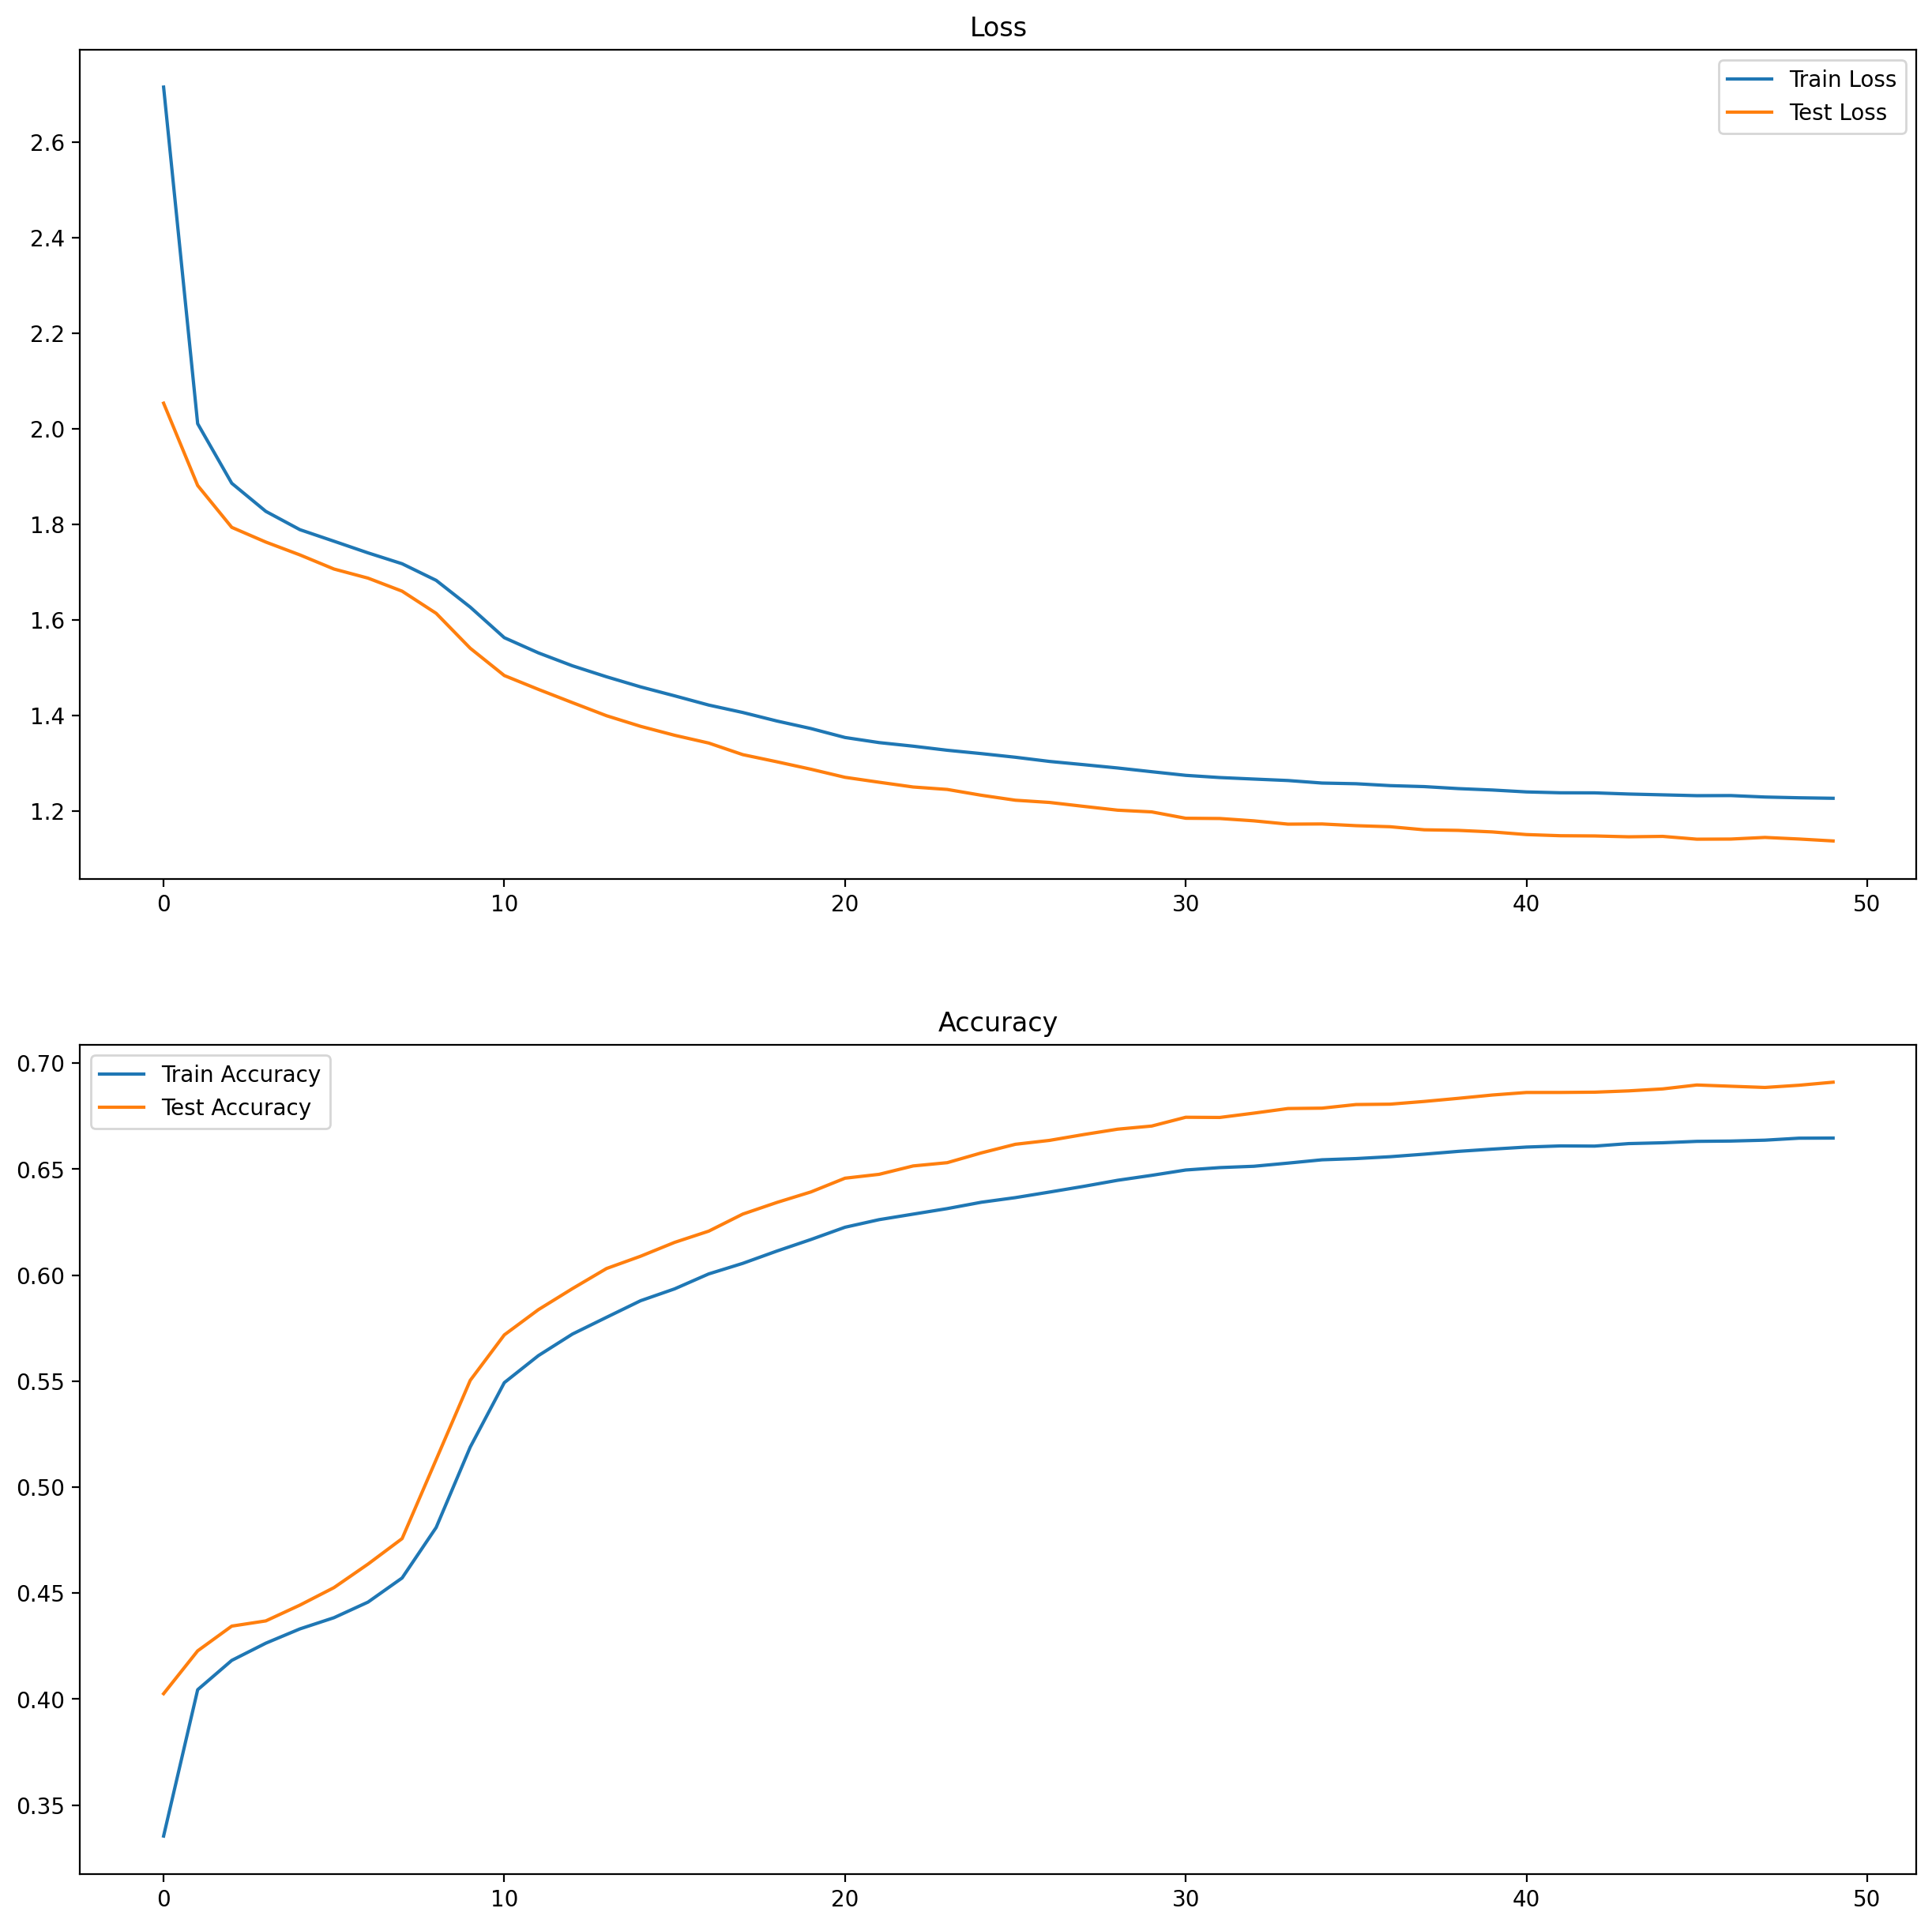

In [14]:
trainer.train()

In [15]:
# Save the model
torch.save(transformer.state_dict(), "../Models/TransformerS.pt")

## Inference

In [16]:
from src import seq_interpreter

interpreter = seq_interpreter.Main(parser)

In [17]:
def pad(x):
    """Pad the input tensor [n] into shape [256] with zeros without the end of sequence token"""
    out = torch.zeros((256))
    out[0] = VOCAB_SIZE - 2 # Start of sequence token
    out[1:1 + len(x)] = x
    return out

In [18]:
def generate_sequence(temperature, max_length):
    transformer.eval()
    with torch.inference_mode():
        x = torch.zeros((1, max_length + 1), dtype=torch.long, device=device)
        
        for i in range(max_length):
            input_x = x[:, :i].squeeze(0)
            input_x = pad(input_x).long().unsqueeze(0)
            y_pred = transformer(input_x.to(device)).squeeze()[i]
            # Zero out the probability for the same as the previous chord
            if i > 0:
                y_pred[x[:, i - 1]] = -torch.inf
            # Sample from the distribution
            y_pred = F.softmax(y_pred, dim=0) ** (1 / temperature)
            x[:, i] = y_pred.multinomial(1).item()
            if x[:, i] == VOCAB_SIZE - 1:
                break
            
    return x[0, :-1]

In [19]:
seq = generate_sequence(1.0, 254)
print(interpreter.token_seq_to_chords(seq))
interpreter.play_seq(seq)

G# | A | G# | F# | C# | D#m | G#m | F# | C# | D#m | G#m | F# | C# | G# | F# | C# | F# | C# | D#m | G#m | F# | C# | F# | C# | D#m | G#m | F# | C# | F# | C# | D#m | G#m | F# | C# | D#m | G#m | F# | C# | B | F# | C# | D#m | G#m | F# | C# | D#m | G#m | F# | C# | B | F# | C# | D#m | G#m | F# | C# | B | F# | C# | D#m | G#m | F# | C# | D#m | G#m | F# | C# | D#m | G#m | F# | C# | F# | C# | D#m | G#m | F# | C# | B | F# | C# | D#m | G#m | F# | C# | F# | B | F# | C# | D#m | G#m | F# | C# | D#m | G#m | F# | C# | D#m | G#m | F# | C# | B | F# | C# | D#m | G#m | F# | G#m | F# | C# | D#m | G#m | F# | C# | D#m | G#m | F# | C# | B | F# | C# | B | F# | C# | D#m | G#m | F# | C# | D#m | B | F#
